In [16]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import os

import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.utils import resample

## Read data

In [7]:
from os.path import dirname

path = dirname(dirname(os.getcwd()))
path

'c:\\Users\\EQDIYCI\\OneDrive - Allianz\\TRAININGS\\DATASCIENCE_ACADEMY\\PROJECT'

In [9]:
data_en = pd.read_pickle(path + "\data\processed\data_en3.pickle")

In [10]:
data_en.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,language,processed_reviews,lem_pos_ner_rem,head_lem_pos_ner_rem
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31,EN,use elit danger mac amaz joystick especi love ...,use_VERB this_PRON for_ADP on_ADP my_PRON mac_...,an_DET amazing_ADJ joystick_NOUN I_PRON especi...
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31,EN,love even realis game mous type silent mous se...,love_VERB it_PRON I_PRON do_AUX not_PART even_...,definitely_ADV a_DET silent_ADJ mouse_NOUN not...
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31,EN,poor qualiti advertis,poor_ADJ quality_NOUN work_NOUN and_CCONJ not_...,star_NOUN
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31,EN,nice tend slip away stick intens hard press ga...,nice_ADJ but_CCONJ tend_VERB to_PART slip_VERB...,good_ADJ but_CCONJ could_AUX be_AUX bettee_VERB
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31,EN,great amiibo great collect qualiti materi desi...,great_ADJ amiibo_NOUN great_ADJ for_ADP collec...,great_ADJ but_CCONJ flawed_ADJ


# Undersampling to reduce calculation load and balance data

!!! headline is not pre-processed?

In [11]:
# need to convert column type to string, otherwise there is float in title --> cannot combine two columns head and review body
data_en['review_headline'] = data_en['review_headline'].astype(str)

In [12]:
data_en["lem_comb"] =  data_en[["lem_pos_ner_rem", "head_lem_pos_ner_rem"]].apply(lambda x: x["head_lem_pos_ner_rem"] + " " + x["lem_pos_ner_rem"] , axis=1)
data_en["head_body"] = data_en[["review_headline", "processed_reviews"]].apply(lambda x: x["review_headline"] + " " + x["processed_reviews"] , axis=1)

In [13]:
# using combined headline and reviewbody for training
X = data_en[["lem_pos_ner_rem","head_lem_pos_ner_rem","lem_comb"][2]]  
X_wo_pos = data_en['head_body']
y = data_en["star_rating"]

In [17]:
rs = [resample(X[y == sr], y[y == sr], X_wo_pos[y == sr], replace=False, 
    n_samples=int(np.floor(1*(X_wo_pos[y == 2].shape[0]))), random_state=123) for sr in [1,2,3,4,5]]


In [18]:
X_list = [rs[r][0] for r in range(5)]
y_list = [rs[r][1] for r in range(5)]
X_wo_pos_list = [rs[r][2] for r in range(5)]

X_us = np.hstack(X_list)
y_us = np.hstack(y_list)
X_wo_pos_us = np.hstack(X_wo_pos_list)

In [19]:
X_us.shape

(469605,)

# PreProcessing

## word2vec from gensim package

Reference: 

1.   https://www.kaggle.com/code/nitin194/twitter-sentiment-analysis-word2vec-doc2vec/#Word2Vec-Features
2.   https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial



Reference the library: 
1.   https://radimrehurek.com/gensim/models/word2vec.html
2.   https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#



In [21]:
from gensim.models import word2vec
import nltk
import gensim

In [22]:
# tokenization of reviews
tokenizer = nltk.WordPunctTokenizer() # extract the tokens from string of words or sentences in the form of Alphabetic and Non-Alphabetic character

X_wo_pos_tok = [tokenizer.tokenize(review) for review in X_wo_pos]
print ("Tokenize the first review:")
print (X_wo_pos_tok[0])

Tokenize the first review:
['an', 'amazing', 'joystick', '.', 'I', 'especially', 'love', 'that', 'you', 'can', 'twist', '...', 'use', 'elit', 'danger', 'mac', 'amaz', 'joystick', 'especi', 'love', 'twist', 'stick', 'differ', 'movement', 'bind', 'well', 'move', 'normal', 'way']


In [24]:
# # tokenization of reviews with posttag
# tokenized_texts_pos = [tokenizer.tokenize(review) for review in reviews_postag]
# print ("Tokenize the first review:")
# print (tokenized_texts_pos[0])

In [ ]:
# # or use the simple preprocess from gensim
# review_posttag_text_w2v = df.lem_pos_ner_rem.apply(gensim.utils.simple_preprocess)

In [38]:
# review_posttag_text_w2v.to_csv(path + "/data/review_posttag_text_w2v.csv", index=False)

### train model

#### self-trained model

In [25]:
%%time
# train w2v model
w2v_model = word2vec.Word2Vec(
                              # sentences=tokenized_texts, # the corpus iterable in the model constructor --> will automatically train the model. build_vocab and train can be saved. What's the difference of 2 training methods?
                              vector_size=200, # desired no. of features/independent variables
                              window=10, # context window size
                              min_count=2, # Ignores all words with total frequency lower than 2.     
                              workers=4, # no.of cores
                              sg = 1, # 1 for skip-gram model
                              negative = 10 # for negative sampling
)

CPU times: total: 0 ns
Wall time: 18 ms


In [27]:
%%time
# building vocabulary, build unique word of vocabulary
w2v_model.build_vocab(X_wo_pos_tok, progress_per=1000)

CPU times: total: 22 s
Wall time: 25.2 s


In [28]:
w2v_model.epochs

5

In [ ]:
w2v_model.corpus_count

1753198

In [39]:
# %%time
# # actual training
# w2v_model.train(X_wo_pos_tok, 
#                 total_examples= w2v_model.corpus_count, 
#                 epochs=w2v_model.epochs # how many times you want to iterate the entire dataset
# )

CPU times: total: 3h 41min 25s
Wall time: 1h 3min 36s


(371309484, 421475945)

In [ ]:
# # save self-trained model
# w2v_model.save(project_path+"/data/trained_model/word2vec_selftrained_0424.model") # save the model if we want to continue training it later

In [ ]:
# # load the pre-trained model
# from gensim.models import KeyedVectors
# w2v_model = KeyedVectors.load(path+'/data/trained_model/word2vec_selftrained_0424.model', mmap='r')

In [41]:
vector = w2v_model.wv['good']  # get numpy vector of a word
sims = w2v_model.wv.most_similar('good', topn=10)  # get other similar words

In [42]:
vector

array([ 0.10384504, -0.22338587,  0.04486185,  0.2599341 ,  0.01930585,
        0.08687989,  0.06622934, -0.17899716,  0.07118305,  0.07105548,
       -0.11962841, -0.00215254, -0.26438522,  0.23579735, -0.1874706 ,
        0.2495736 , -0.11199171,  0.24751261,  0.22111078,  0.0836027 ,
       -0.01948962,  0.10527959, -0.15203692,  0.13376005,  0.3714411 ,
        0.20535709, -0.34948862,  0.0481569 ,  0.06260397,  0.24223758,
        0.13596196, -0.20201056,  0.36209905,  0.12880695,  0.43357188,
        0.02629136,  0.1222094 ,  0.3357244 , -0.07303182, -0.2776628 ,
       -0.08185345, -0.2209961 ,  0.2692965 , -0.03503795, -0.09387101,
        0.08730807, -0.08026947, -0.04479478,  0.04336164,  0.37308443,
       -0.09171795, -0.344091  ,  0.13822182, -0.12009016, -0.02423117,
        0.09335303,  0.30791113, -0.2566434 ,  0.09070587,  0.00541392,
       -0.2287879 , -0.17454253, -0.12369674, -0.17370552,  0.01700998,
       -0.11728077, -0.27819586, -0.04514389,  0.10027508,  0.06

In [43]:
sims # why the similarity between bad and good is is bigger than between good and nice? 

[('great', 0.8732665181159973),
 ('bad', 0.8137128949165344),
 ('realli', 0.7890716791152954),
 ('think', 0.7756370902061462),
 ('br', 0.7749637961387634),
 ('like', 0.7711126804351807),
 ('excel', 0.7689862847328186),
 ('game', 0.7678406238555908),
 ('howev', 0.7578579783439636),
 ('cool', 0.7549959421157837)]

In [44]:
w2v_model.wv.similarity(w1="great", w2="good")

0.8732666

In [45]:
w2v_model.wv.similarity(w1="good", w2="bad")

0.81371284

In [89]:
# getting the training loss value
training_loss = w2v_model.get_latest_training_loss()
print(training_loss)

0.0


##### plots

In [159]:
# t-SNE visualizations
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 200), dtype='f') # in the training of model above only 200 features set
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays) # min(n_samples, n_features)=19
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(12)

    
    plt.xlim(Y[:, 0].min()-5, Y[:, 0].max()+5)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()*1.1)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

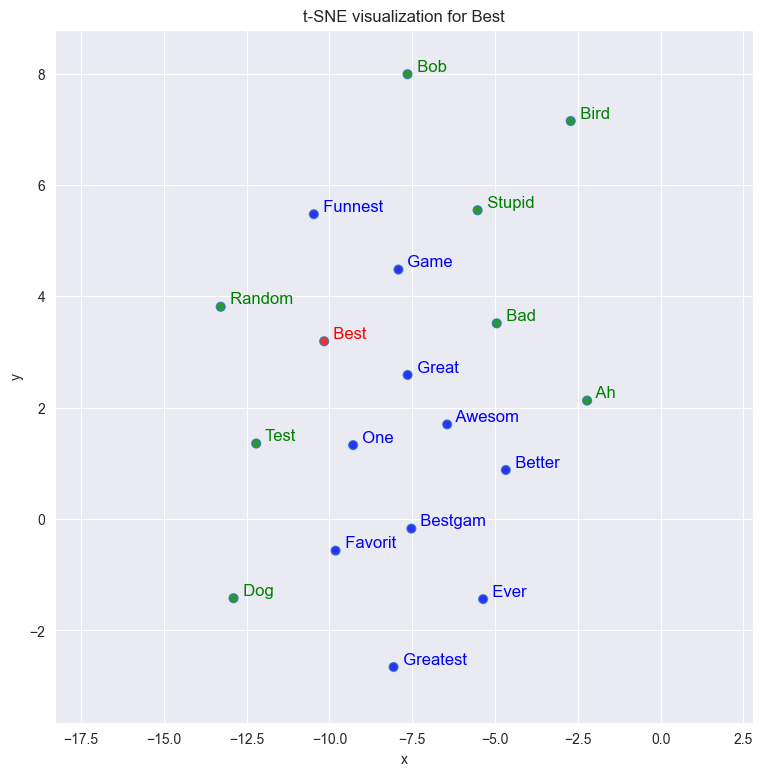

In [160]:
tsnescatterplot(w2v_model, 'best', ['dog', 'bird', 'ah', 'test', 'bob', 'random', 'bad', 'stupid'])

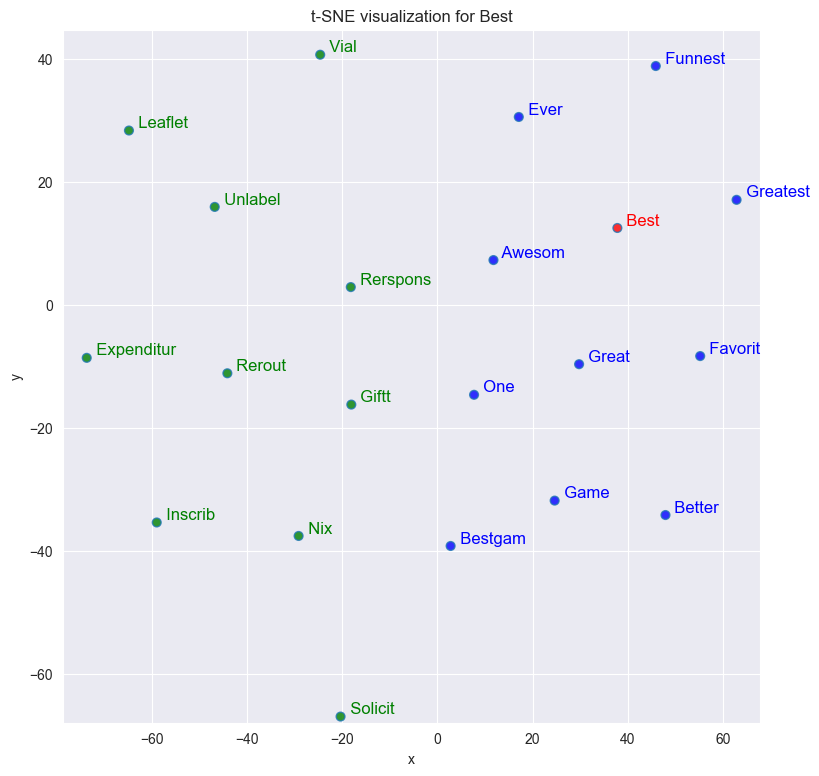

In [161]:
# 10 Most similar words vs. 10 Most dissimilar
tsnescatterplot(w2v_model, 'best', [i[0] for i in w2v_model.wv.most_similar(negative=["best"])])

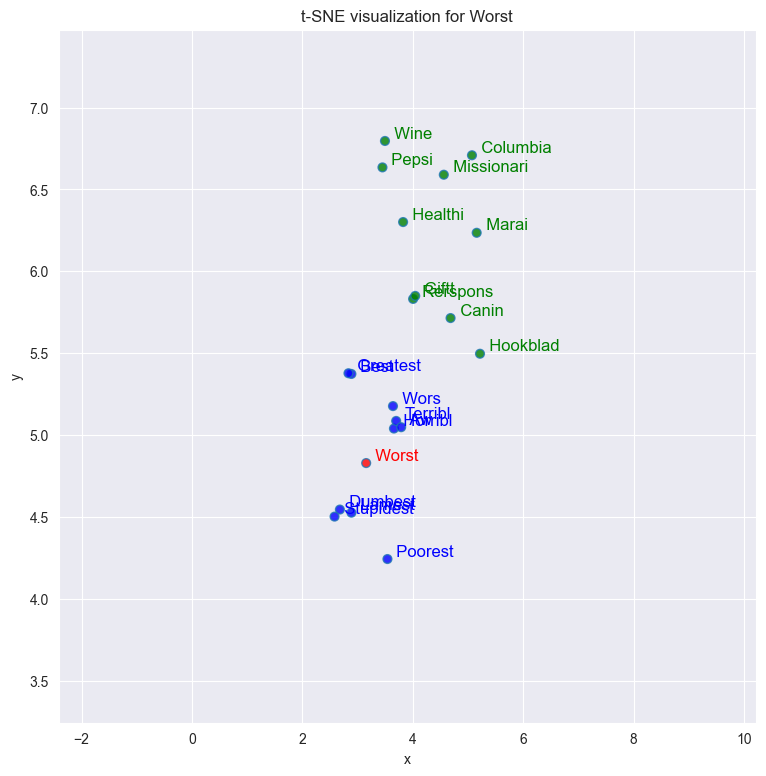

In [162]:
# 10 Most similar words vs. 10 Most dissimilar
# the cluster does not look super good. 
tsnescatterplot(w2v_model, 'worst', [i[0] for i in w2v_model.wv.most_similar(negative=["worst"])])

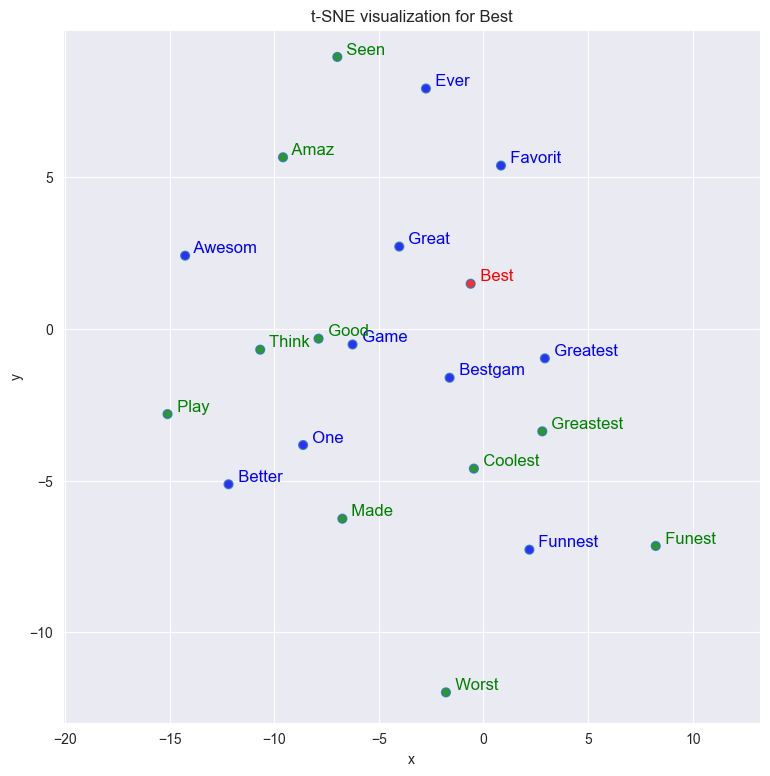

In [163]:
# 10 Most similar words vs. 11th to 20th Most similar words
tsnescatterplot(w2v_model, "best", [t[0] for t in w2v_model.wv.most_similar(positive=["best"], topn=20)][10:])

##### prepare w2v vector

In [ ]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += w2v_model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
##time
# wordvec_arrays = np.zeros((len(review_text_w2v), 200)) 

# print(len(review_text_w2v))

# sum = 0
# for i in range(len(review_text_w2v)):
#   try:
#     wordvec_arrays[i,:] = word_vector(review_text_w2v[i], 200)
#   except KeyError: # handling the case where the token is empty --> need to reset index of the original df after pre-processing
#       sum=sum+1
#       continue
  
# wordvec_df = pd.DataFrame(wordvec_arrays)
# wordvec_df.shape

1753198


(1753198, 200)

In [ ]:
# wordvec_df.to_csv(path+"/wordvec_df_selftrained.csv", index=False)

In [ ]:
wordvec_df = pd.read_csv(path+"/wordvec_df.csv").iloc[: , 1:] # .iloc is not necessary once the index is false by exporting to csv

In [ ]:
wordvec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.078583,-0.192878,-0.079541,0.247846,0.162258,-0.095314,0.104692,-0.069279,0.037269,0.052816,...,0.165681,0.137868,-0.077058,-0.127965,0.123229,-0.092136,0.031361,-0.076171,-0.099737,0.067898
1,0.036337,-0.248248,0.000821,0.190390,0.106928,-0.090561,0.031567,-0.091227,0.072606,-0.020614,...,0.153220,0.123923,-0.022624,-0.137044,0.093592,-0.143693,0.027180,0.048371,-0.060761,0.005081
2,0.087802,-0.255182,-0.094120,0.180695,0.057108,-0.290745,0.200662,-0.068404,-0.107756,-0.023572,...,0.136470,0.136953,-0.087375,-0.071639,-0.069902,-0.179526,-0.096846,-0.068905,-0.027144,0.030770
3,-0.106207,-0.051366,-0.067495,0.090028,-0.106640,-0.194748,-0.052490,0.062290,0.251072,-0.025374,...,0.252599,0.039660,-0.093815,-0.070699,0.009014,-0.074410,-0.046123,-0.056323,-0.119209,-0.024711
4,-0.040154,-0.164538,-0.056990,0.130402,0.034597,-0.104752,0.063230,-0.068794,-0.032222,0.031723,...,0.163015,0.143688,-0.019524,-0.103870,0.056815,-0.150317,0.023394,0.049077,-0.026821,-0.072236


#### pre-trained model -- google news model

Reference: 

1. https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/
2. https://thinkingneuron.com/how-to-classify-text-using-word2vec/#GloVe

using google news model > needs to be downloaded from google drive (link (cannot be opened in working laptop): https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

In [127]:
# loading the word vectors from Google trained word2vec model
GoogleModel = gensim.models.KeyedVectors.load_word2vec_format(path + '/data/trained_model/GoogleNews-vectors-negative300.bin.gz', binary=True,)

In [129]:
GoogleModel['Best'].shape

(300,)

In [130]:
GoogleModel.most_similar('best', topn=10)

[('finest', 0.6383626461029053),
 ('worst', 0.5835109949111938),
 ('greatest', 0.5824128985404968),
 ('strongest', 0.5785794258117676),
 ('smartest', 0.5695626735687256),
 ('easiest', 0.5528990626335144),
 ('good', 0.5467195510864258),
 ('thebest', 0.5430119633674622),
 ('quickest', 0.5399829149246216),
 ('healthiest', 0.5372903943061829)]

In [177]:
GoogleModel.__getitem__(['good'])

array([[ 0.04052734,  0.0625    , -0.01745605,  0.07861328,  0.03271484,
        -0.01263428,  0.00964355,  0.12353516, -0.02148438,  0.15234375,
        -0.05834961, -0.10644531,  0.02124023,  0.13574219, -0.13183594,
         0.17675781,  0.27148438,  0.13769531, -0.17382812, -0.14160156,
        -0.03076172,  0.19628906, -0.03295898,  0.125     ,  0.25390625,
         0.12695312, -0.15234375,  0.03198242,  0.01135254, -0.01361084,
        -0.12890625,  0.01019287,  0.23925781, -0.08447266,  0.140625  ,
         0.13085938, -0.04516602,  0.06494141,  0.02539062,  0.05615234,
         0.24609375, -0.20507812,  0.23632812, -0.00860596, -0.02294922,
         0.05078125,  0.10644531, -0.03564453,  0.08740234, -0.05712891,
         0.08496094,  0.23535156, -0.10107422, -0.03564453, -0.04736328,
         0.04736328, -0.14550781, -0.10986328,  0.14746094, -0.23242188,
        -0.07275391,  0.19628906, -0.37890625, -0.07226562,  0.04833984,
         0.11914062,  0.06103516, -0.12109375, -0.2

##### plots (tbd)

In [180]:
# t-SNE visualizations
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f') # in the training of model above only 200 features set
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays) # min(n_samples, n_features)=19
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(12)

    
    plt.xlim(Y[:, 0].min()-5, Y[:, 0].max()+5)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()*1.1)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

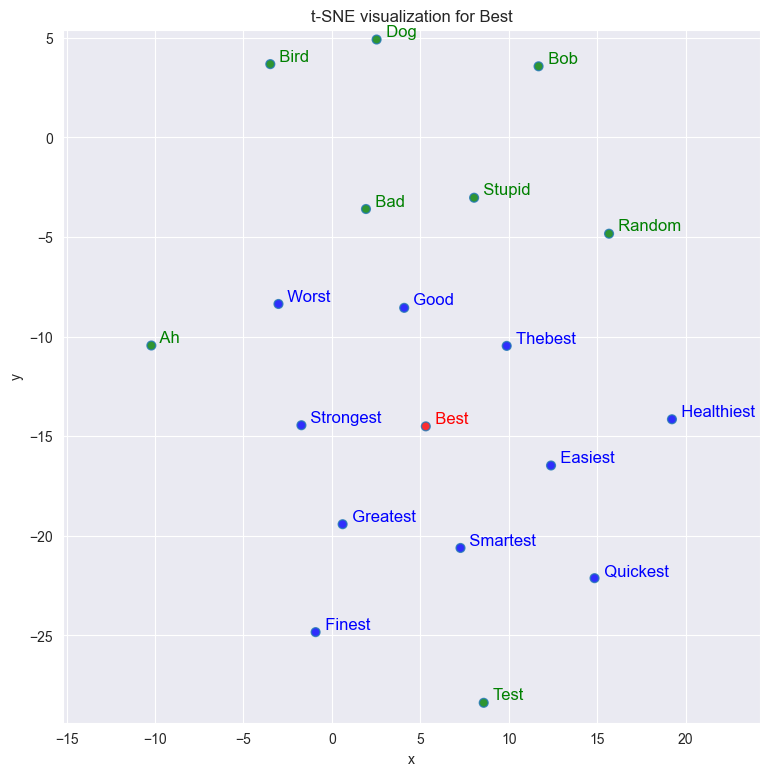

In [181]:
tsnescatterplot(GoogleModel, 'best', ['dog', 'bird', 'ah', 'test', 'bob', 'random', 'bad', 'stupid'])

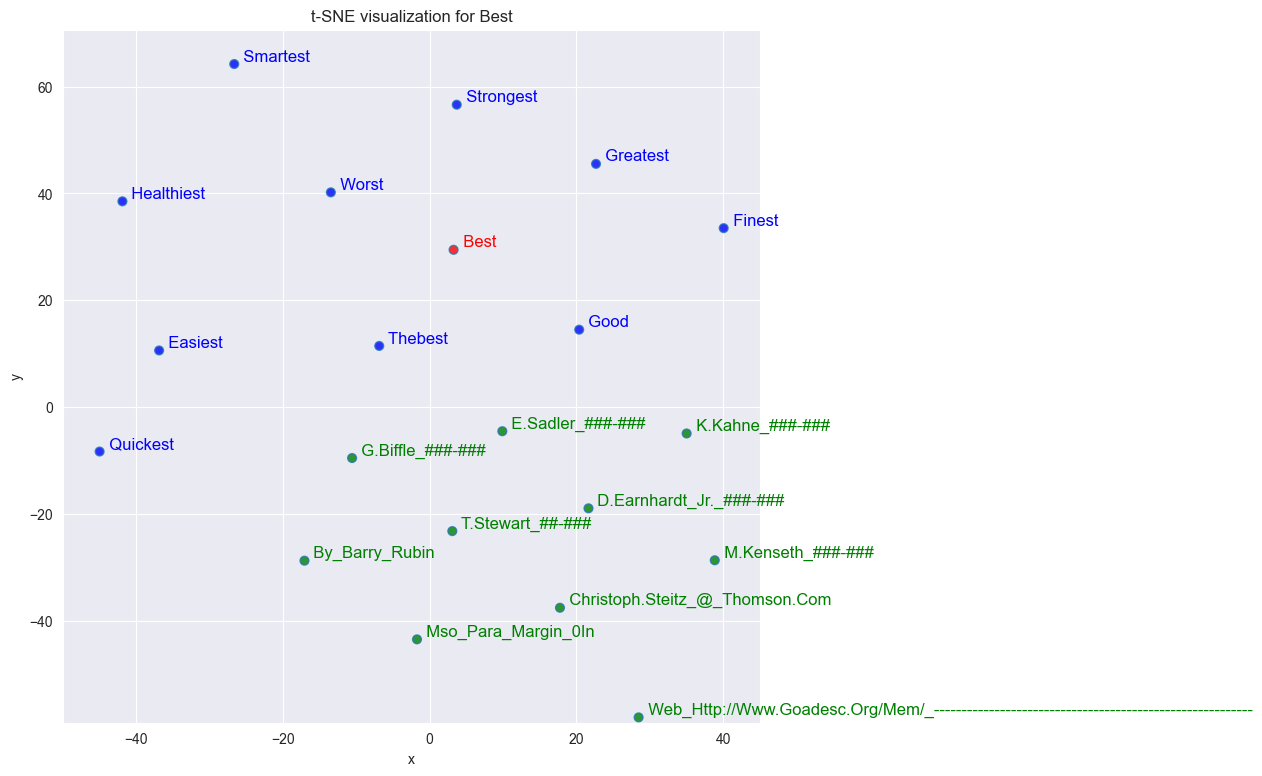

In [183]:
# 10 Most similar words vs. 10 Most dissimilar
tsnescatterplot(GoogleModel, 'best', [i[0] for i in GoogleModel.most_similar(negative=["best"])])

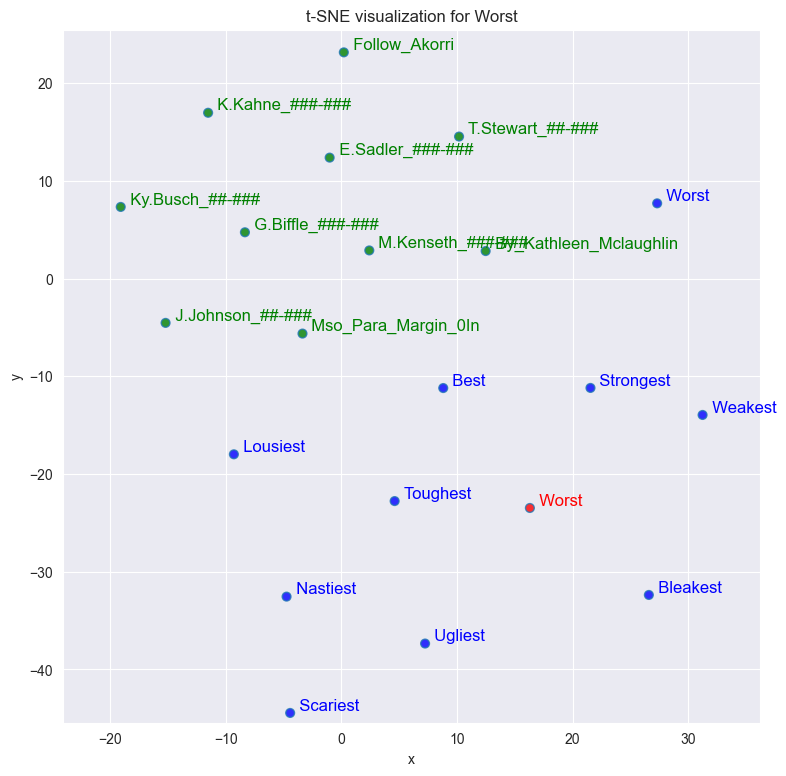

In [185]:
# 10 Most similar words vs. 10 Most dissimilar
# the cluster does not look super good. 
tsnescatterplot(GoogleModel, 'worst', [i[0] for i in GoogleModel.most_similar(negative=["worst"])])

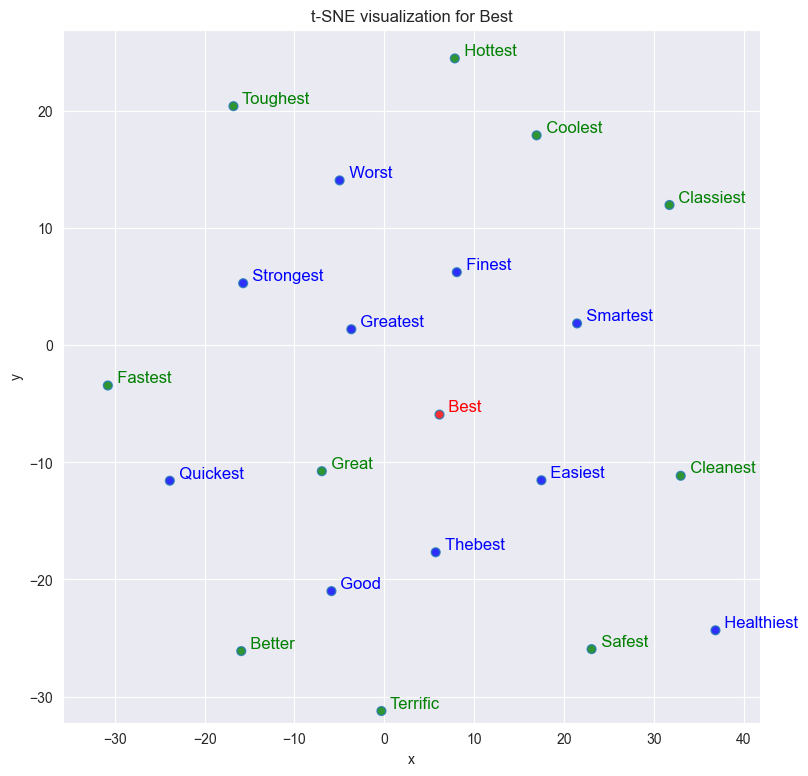

In [187]:
# 10 Most similar words vs. 11th to 20th Most similar words
tsnescatterplot(GoogleModel, "best", [t[0] for t in GoogleModel.most_similar(positive=["best"], topn=20)][10:])

##### prepare w2v vector

In [191]:
from sklearn.feature_extraction.text import CountVectorizer 

corpus = reviews

vectorizer = CountVectorizer(stop_words='english')

X = vectorizer.fit_transform(corpus)

In [192]:
def FunctionText2Vec(inpTextData):
    # Converting the text to numeric data

    X = vectorizer.transform(inpTextData)
    CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

    # Creating empty dataframe to hold sentences
    W2Vec_Data=pd.DataFrame()

    # Looping through each row for the data
    for i in range(CountVecData.shape[0]):

        # initiating a sentence with all zeros
        Sentence = np.zeros(300)

        # Looping thru each word in the sentence and if its present in
        # the Word2Vec model then storing its vector
        for word in WordsVocab[CountVecData.iloc[i , :]>=1]:
            #print(word)
            if word in GoogleModel.key_to_index.keys():
                Sentence=Sentence+GoogleModel[word]
        # Appending the sentence to the dataframe
        W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
    return(W2Vec_Data)

In [193]:
wordvec_pretrained_df = FunctionText2Vec(review_text_w2v)

AttributeError: 'list' object has no attribute 'lower'

In [194]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += GoogleModel[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [196]:
##time
wordvec_arrays = np.zeros((len(review_text_w2v), 300)) 

print(len(review_text_w2v))

sum = 0
for i in range(len(review_text_w2v)):
  try:
    wordvec_arrays[i,:] = word_vector(review_text_w2v[i], 300)
  except KeyError: # handling the case where the token is empty --> need to reset index of the original df after pre-processing
      sum=sum+1
      continue
  
wordvec_pretrained_df = pd.DataFrame(wordvec_arrays)
wordvec_pretrained_df.shape

1753198


(1753198, 300)

In [198]:
wordvec_pretrained_df.to_csv(path+"/data/wordvec_df_selftrained.csv", index=False)

## evaluation

### logisticRegression

In [213]:
lreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) #default max_iter=100 is not enough --> no convergence. verbose=1 does not work for the multiclass/multilabel

#### word2vec

##### self trained

In [114]:
 X_train, X_test, y_train, y_test = train_test_split(wordvec_df, df['star_rating'], test_size=0.2, random_state=123)

#  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [115]:
print(np.shape(X_train),np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))

(1402558, 200) (1402558,)
(350640, 200) (350640,)


In [118]:
lreg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min finished


LogisticRegression(max_iter=1000, multi_class='multinomial', verbose=1)

In [119]:
y_pred = lreg.predict(X_test)
# y_pred = y_pred.astype(int)

In [120]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') # https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#:~:text=The%20weighted%2Daveraged%20F1%20score,the%20class%20in%20the%20dataset.
recall = recall_score(y_test, y_pred, average='weighted')

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)

c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy: 0.5722650011407712
precision: 0.327488165503284
recall: 0.5722650011407712


In [121]:
print(classification_report(y_test, y_pred))

c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00     37664
           2       0.00      0.00      0.00     18725
           3       0.00      0.00      0.00     30686
           4       0.00      0.00      0.00     62906
           5       0.57      1.00      0.73    200659

    accuracy                           0.57    350640
   macro avg       0.11      0.20      0.15    350640
weighted avg       0.33      0.57      0.42    350640



c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
labels = [1,2,3,4,5]
cm = confusion_matrix(y_test, y_pred, labels = labels)
print(cm)

[[     0      0      0      0  37664]
 [     0      0      0      0  18725]
 [     0      0      0      1  30685]
 [     0      0      0      0  62906]
 [     0      0      0      0 200659]]


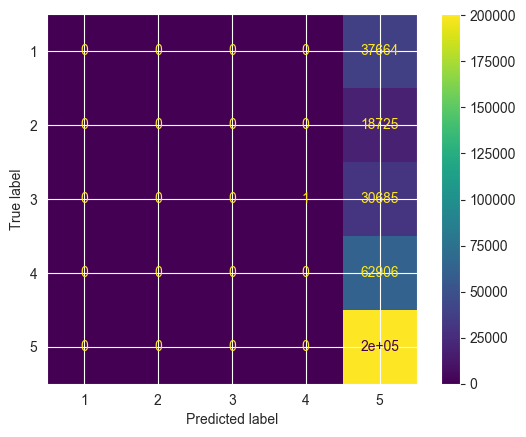

In [123]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lreg.classes_)
disp.plot()
plt.show()

In [124]:
# evaluate multinomial logistic regression model
# define dataset
X_train, y_train = make_classification(n_samples=10000, n_features=200, n_informative=5, n_redundant=5, n_classes=3, random_state=1)

# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.629 (0.017)


In [125]:
# X_train, y_train = make_classification(n_samples=10000, n_features=200, n_informative=5, n_redundant=5, n_classes=3, random_state=1)

# define the multinomial logistic regression model
# model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# fit the model on the whole dataset
model.fit(X_train, y_train)

# predict the class label
y_prediction = model.predict(X_test)

f1_score = f1_score(y_test, y_prediction, average='weighted')
accuracy_score = accuracy_score(y_test, y_prediction)

print('f1_score: %.3f' % (f1_score))
print("accuracy_score %.3f" % (accuracy_score))

f1_score: 0.005
accuracy_score 0.053


##### pre-trained

In [207]:
X_train, X_test, y_train, y_test = train_test_split(wordvec_pretrained_df, df['star_rating'], test_size=0.2, random_state=123)

#  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [200]:
print(np.shape(X_train),np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))

(1402558, 300) (1402558,)
(350640, 300) (350640,)


In [210]:
lreg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min finished


LogisticRegression(max_iter=1000, multi_class='multinomial', verbose=1)

In [211]:
y_pred = lreg.predict(X_test)
y_pred = y_pred.astype(int)

In [214]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') # https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#:~:text=The%20weighted%2Daveraged%20F1%20score,the%20class%20in%20the%20dataset.
recall = recall_score(y_test, y_pred, average='weighted')

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)

TypeError: 'numpy.float64' object is not callable

In [ ]:
print(classification_report(y_test, y_pred))

c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00     37664
           2       0.00      0.00      0.00     18725
           3       0.00      0.00      0.00     30686
           4       0.17      0.00      0.00     62906
           5       0.57      1.00      0.73    200659

    accuracy                           0.57    350640
   macro avg       0.15      0.20      0.15    350640
weighted avg       0.36      0.57      0.42    350640



c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [215]:
labels = [1,2,3,4,5]
cm = confusion_matrix(y_test, y_pred, labels = labels)
print(cm)

[[     0      0      0      2  37662]
 [     0      0      0      0  18725]
 [     0      0      0      0  30686]
 [     0      0      0      1  62905]
 [     0      1      0      3 200655]]


In [ ]:
stop

example code > the following code is not working properly? the accuracy score is extremly low

In [ ]:
train = df.iloc[:31962,:]
train.head()

,star_rating,review_headline,processed_reviews,reviews
0,4,Quite Good,easi setup use digit input one best wireless h...,easi setup use digit input one best wireless h...
1,4,The headphones sound great; they are comfortab...,go refurbish rout worth save headphon sound gr...,go refurbish rout worth save headphon sound gr...
2,5,Perfect replacement,work great replac lost origin,work great replac lost origin
3,4,Lots of action,game allow novic like world champ also let mov...,game allow novic like world champ also let mov...
4,5,Great Protection at a Great Price!,specif protector review insten brand protector...,specif protector review insten brand protector...


In [ ]:
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

# splitting data into training and validation set 
xtrain_w2v, xvalid_w2v, ytrain, yvalid = train_test_split(train_w2v, train['star_rating'], random_state=42, test_size=0.3)

In [ ]:
xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

lreg.fit(xtrain_w2v, ytrain)

prediction = lreg.predict_proba(xvalid_w2v)

prediction_int = np.rint(prediction)
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int, average='weighted') # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-66-992cfc4679c5>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/re

ValueError: ignored

In [ ]:
accuracy_score(yvalid, prediction_int)

0.0010428616122640526

#### tfidf

In [49]:
# with reviews
X_train, X_test, y_train, y_test = train_test_split(df.reviews, df['star_rating'], test_size=0.2, random_state=123)

tfidf_vectorizer.fit(X_train)
tfidf_train = tfidf_vectorizer.transform(X_train)
tfidf_test  = tfidf_vectorizer.transform(X_test)

NameError: name 'lreg' is not defined

In [51]:
lreg.fit(tfidf_train, y_train) 

y_pred = lreg.predict(tfidf_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min finished


In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.58      0.65      0.61     37664
           2       0.36      0.09      0.14     18725
           3       0.37      0.16      0.22     30686
           4       0.45      0.19      0.26     62906
           5       0.71      0.93      0.80    200659

    accuracy                           0.66    350640
   macro avg       0.49      0.40      0.41    350640
weighted avg       0.60      0.66      0.60    350640



In [53]:
accuracy_score(y_test, y_pred)

0.6550222450376455

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df['lem_pos_ner_rem'], df['star_rating'], test_size=0.2, random_state=123)

tfidf_vectorizer.fit(X_train)
tfidf_train = tfidf_vectorizer.transform(X_train)
tfidf_test  = tfidf_vectorizer.transform(X_test)

In [63]:
lreg.fit(tfidf_train, y_train) 

y_pred = lreg.predict(tfidf_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min finished


In [64]:
print(classification_report(y_test, y_pred))
print('accuracy score: ', accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.60      0.68      0.64     37664
           2       0.35      0.09      0.15     18725
           3       0.37      0.20      0.26     30686
           4       0.46      0.23      0.31     62906
           5       0.73      0.92      0.81    200659

    accuracy                           0.67    350640
   macro avg       0.50      0.43      0.43    350640
weighted avg       0.61      0.67      0.62    350640

accuracy score:  0.665508783937942


[[ 25651   1234   1553    714   8512]
 [  6543   1770   2932   1556   5924]
 [  3915   1316   6058   6187  13210]
 [  2284    473   3806  14631  41712]
 [  4270    224   2001   8920 185244]]


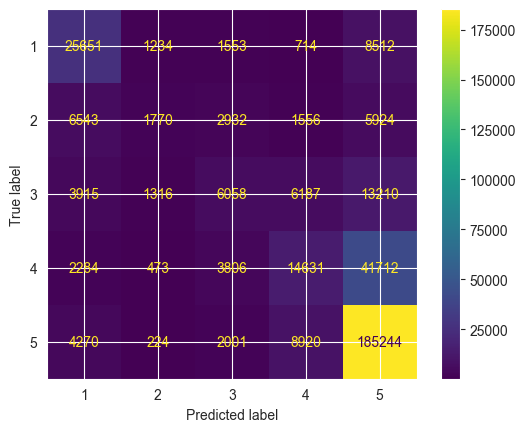

In [65]:
labels = [1,2,3,4,5]
cm = confusion_matrix(y_test, y_pred, labels = labels)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lreg.classes_)
disp.plot()
plt.show()

In [ ]:
STOP

In [59]:
# test with pipeline > not working properly yet
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 

def mod_tfidf(df, y_col, x_col, size):

    tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
    # tfidf = tfidf_vectorizer.fit_transform(df['reviews'])
    # tfidf.shape
    X_train, X_test, y_train, y_test = train_test_split(df[y_col], df[x_col], test_size=size, random_state=123)
    tfidf_vectorizer.fit(X_train)
    tfidf_train = tfidf_vectorizer.transform(X_train)
    tfidf_test  = tfidf_vectorizer.transform(X_test)

    lreg.fit(tfidf_train, y_train) #
    y_pred = lreg.predict(tfidf_test)

    print(classification_report(y_test, y_pred))
    print('accuracy score: ', accuracy_score(y_test, y_pred))

In [60]:
mod_tfidf(df, y_col='star_rating', x_col='lem_pos_ner_rem', size=0.2)

AttributeError: 'int' object has no attribute 'lower'

In [57]:
df.head(1)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,language,processed_reviews,lem_pos_ner_rem,reviews
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31,EN,use elit danger mac amaz joystick especi love ...,use_VERB this_PRON for_ADP on_ADP my_PRON mac_...,use elit danger mac amaz joystick especi love ...


#### pipeline

In [ ]:
logreg = Pipeline([('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('clf', LogisticRegression(n_jobs=1, C=1e5, solver='lbfgs',multi_class='ovr' ,random_state=0, class_weight='balanced' )),
           ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print('Logistic Regression Accuracy %s' % accuracy_score(y_pred, y_test))

cv_score = cross_val_score(logreg, train_tfidf, y_train, cv=10, scoring='accuracy')
print("CV Score : Mean : %.7g | Std : %.7g | Min : %.7g | Max : %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

In [ ]:
stop

In [ ]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

# takes long
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(w2v_model)


KeyboardInterrupt: ignored

In [ ]:
def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

try:
    get_ipython()
except Exception:
    plot_function = plot_with_matplotlib
else:
    plot_function = plot_with_plotly

plot_function(x_vals, y_vals, labels)